In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import gc
import pickle

## Introduction

This is my solution for the following Kaggle competition:
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/overview

The goal is to classify ad click data on whether the click was followed by an application download or not. I decided to use LightGBM because the data has mostly categorical features and is large, making it suitable for LGBM.

To be able to run this Notebook, please download the train.csv and test.csv from:
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

## Load data

In [2]:
%%time
# assign dtypes to reduce memory use
dtypes = {
    'click_id': 'uint32',
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}
# attributed time is not read because it is not a feature of test data
train_df = pd.read_csv('input/train.csv', header=0, sep=',', 
                       dtype=dtypes, parse_dates=['click_time'],
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])

Wall time: 4min 46s


In [3]:
%%time
test_df = pd.read_csv('input/test.csv', header=0, sep=',', 
                       dtype=dtypes, parse_dates=['click_time'],
                       usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
gc.collect();

Wall time: 30.9 s


7

In [4]:
print('Loaded...')

Loaded...


## EDA

In [6]:
# data set sizes in rows
print("Train: "+str(len(train_df))+" rows")
print("Test:  "+str(len(test_df))+" rows")

Train: 184903890 rows
Test:  18790469 rows


In [11]:
# check out rows
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [19]:
train_df.tail()

,ip,app,device,os,channel,click_time,is_attributed
184903885,121312,12,1,10,340,2017-11-09 16:00:00,0
184903886,46894,3,1,19,211,2017-11-09 16:00:00,0
184903887,320126,1,1,13,274,2017-11-09 16:00:00,0
184903888,189286,12,1,37,259,2017-11-09 16:00:00,0
184903889,106485,11,1,19,137,2017-11-09 16:00:00,0


In [12]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [13]:
# unique categories
cols = ['ip', 'app', 'device', 'os', 'channel']
print('Train')
for col in cols:
    print('Number of unique '+col+': '+str(train_df[col].nunique()))
    
print('\nTest')
for col in cols:
    print('Number of unique '+col+': '+str(test_df[col].nunique()))

Train
Number of unique ip: 277396
Number of unique app: 706
Number of unique device: 3475
Number of unique os: 800
Number of unique channel: 202

Test
Number of unique ip: 93936
Number of unique app: 417
Number of unique device: 1985
Number of unique os: 395
Number of unique channel: 178


In [16]:
# proportion of attributed clicks in train
print("Proportion attributed: "+str(train_df.is_attributed.mean()))

Proportion attributed: 0.002470721410998979


Very few of the entries are attributed.

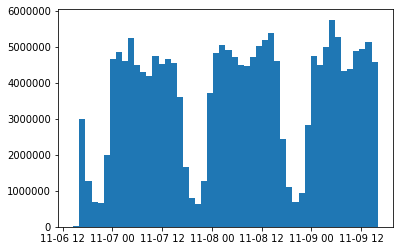

In [20]:
# check click times distribution
plt.hist(train_df.click_time, 50);

Click times for three consecutive days in train

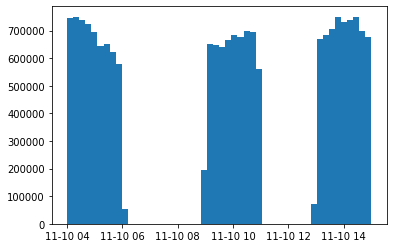

In [21]:
# check click times distribution
plt.hist(test_df.click_time, 50);

Forth day in test set.

Are the click times sorted?

In [10]:
train_df.click_time.is_monotonic, test_df.click_time.is_monotonic

(True, True)

click_time columns are sorted in the data frames

### Sanity checks

In [14]:
# dtypes
train_df.dtypes

ip                       uint32
app                      uint16
device                   uint16
os                       uint16
channel                  uint16
click_time       datetime64[ns]
is_attributed             uint8
dtype: object

In [15]:
test_df.dtypes

click_id              uint32
ip                    uint32
app                   uint16
device                uint16
os                    uint16
channel               uint16
click_time    datetime64[ns]
dtype: object

Make sure there are no NaN values.

In [7]:
train_df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [8]:
test_df.isna().sum()

click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64

## Feature Engineering

### Downsampling of train data

I have decided to apply the strategy of negative down-sampling on the train data as the winning team did in the competition:
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56475#latest-436248

This means that all the few data points classified as attributed are kept for model training, while an equal amount of negative points (i.e. not attributed) are randomly sampled from the rest of the train data. In this way the train data is shrinked to a manageable amount. 

In [22]:
# count number of attributed clicks
attr_mask = train_df.is_attributed == 1
nattr = attr_mask.sum()

In [23]:
# keep the original train data set as it will be required for feature engineering
original_train = train_df.reset_index()

In [24]:
%%time
# downsample the non-attributed data to balance labels
sample_train_df = original_train[original_train.is_attributed != 1].sample(n=nattr, random_state=1) #[:nattr]

Wall time: 3min 15s


In [25]:
train_df = sample_train_df.append(original_train[attr_mask])
train_df = train_df.sort_index()
del sample_train_df
gc.collect()

52365

In [36]:
print("Size of downsampled train data set: "+str(len(train_df))+" rows")

Size of downsampled train data set: 913692 rows


### New features

The feature selection was made based on information of what worked for other succesful competitors:
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56406#latest-329920

The most important feature seems to be the finite difference between adjacent click times (1 or 2 steps, backward or forward) in groups made on combinations of the cateogorical features. I implemented my own way of calculating the features below.

In [37]:
# features derived from groups of train data grouped by different combincations of columns
def fe_group_by(df, cols):
    
    feat = []

    # create group by
    gb_times = df[cols+['click_time']].groupby(cols)
    # calculate 1 step diff
    time_diff_1 = (gb_times.click_time.shift(-1) - df.click_time).dt.seconds
    gc.collect();
    # add features
    # 1 step forward difference
    feat.append('time_1step_diff_' + '_'.join(cols))
    df[feat[-1]] = time_diff_1
    # 1 step backward difference
    feat.append('time_-1step_diff_' + '_'.join(cols))
    df[feat[-1]] = time_diff_1.shift(1)
    # 2 step forward difference
    feat.append('time_2step_diff_' + '_'.join(cols))
    df[feat[-1]] = time_diff_1 + time_diff_1.shift(-1)
    # 2 step backward difference
    feat.append('time_-2step_diff_' + '_'.join(cols))
    df[feat[-1]] = df['time_2step_diff_' + '_'.join(cols)].shift(2)
    # click count
    feat.append('click_count_' + '_'.join(cols))
    df = df.merge(gb_times.click_time.count().rename(feat[-1]), how='left', on=cols) 

    gc.collect();
    
    return df, feat

Because the randomly sampled data belongs to groups in the original data set, we need to work with the original data set to calculate the group level features of the selected rows. Therefore, a merge based on the columns on which the ggrouping is made is necessary.

The size of the data makes it impossible to calculate the group features at once on my laptop. Therefore I decided to split the train data groups into chunks, then merge it with the original data and calulate group features on the chunks, in a serial way. This is feasible with the current computing resources.

Once the features are calculated, another merge is made between the rows corresponding to the chunk in the downsampled set and the same rows in the chunk for which the features were calculated.

From the click time, only the hour was kept as a feature for model training.

In [27]:
# features by which to split into groups
group_by_cols = [
    ['ip', 'os', 'device', 'app'],
    ['ip', 'os', 'device', 'app', 'channel']
]

def fe(df, original, nchunks):
    
    predictors=['ip', 'app', 'device', 'os', 'channel']
    
    for cols in group_by_cols:
        
        groups = df[cols].drop_duplicates() # unique combinations of the categories in cols
        chunks = np.array_split(groups, nchunks) # split into chunks used for group_by features
        feat_chunks = []
        
        print(cols)
        
        for i, chunk in enumerate(chunks):
            print('Chunk '+str(i))
            # join chunk with the rest of the data
            df_for_groupby = chunk.merge(original, how='left', on=cols)
            print("Merge groups done...")
            gc.collect()
            # calculate features of groups
            df_for_groupby, ft = fe_group_by(df_for_groupby, cols)
            print("Calculating features on groups done...")
            gc.collect()
            # collect chunks of features
            feat_chunks.append(chunk.merge(df, how='left', on=cols)
                               .merge(df_for_groupby[ft+['index']], how='left',
                                      on='index'))
            print("Merge with train data done...\n")
            del df_for_groupby
            gc.collect()
            
        # update df
        df = pd.concat(feat_chunks)
        predictors += ft
        
    # hour as feature
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('int8')
    predictors.append('hour')

    gc.collect();
    
    return df, predictors

In [30]:
%%time
train_df, predictors = fe(train_df, original_train, 12)

['ip', 'os', 'device', 'app']
Chunk 0
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 1
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 2
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 3
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 4
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 5
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 6
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 7
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 8
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Chunk 9
Merge groups done...
Calculating features on groups done...
Merge with 

In [43]:
print("Predictors used for training: ", *['\n'+p for p in predictors])

Predictors used for training:  
ip 
app 
device 
os 
channel 
time_1step_diff_ip_os_device_app 
time_-1step_diff_ip_os_device_app 
time_2step_diff_ip_os_device_app 
time_-2step_diff_ip_os_device_app 
click_count_ip_os_device_app 
time_1step_diff_ip_os_device_app_channel 
time_-1step_diff_ip_os_device_app_channel 
time_2step_diff_ip_os_device_app_channel 
time_-2step_diff_ip_os_device_app_channel 
click_count_ip_os_device_app_channel 
hour


In [32]:
with open('train_df.pickle','wb') as pckl_file:
    pickle.dump(train_df, pckl_file)

In [33]:
%%time
test_df.reset_index(inplace=True)
test_df, feat = fe(test_df, test_df, 1)
gc.collect();

['ip', 'os', 'device', 'app']
Chunk 0
Merge groups done...
Calculating features on groups done...
Merge with train data done...

['ip', 'os', 'device', 'app', 'channel']
Chunk 0
Merge groups done...
Calculating features on groups done...
Merge with train data done...

Wall time: 2min 22s


28

In [34]:
with open('test_df.pickle','wb') as pckl_file:
    pickle.dump(test_df, pckl_file)

In [41]:
with open('predictors.pickle','wb') as pckl_file:
    pickle.dump(predictors, pckl_file)

In [35]:
gc.collect()

0

## Model creation

The model used is LGBM with parameters set as in:
https://www.kaggle.com/asraful70/notebook-version-of-talkingdata-lb-0-9786

In [2]:
with open('train_df.pickle','rb') as pckl_file:
    train_df = pickle.load(pckl_file)

In [3]:
with open('test_df.pickle','rb') as pckl_file:
    test_df = pickle.load(pckl_file)

In [42]:
with open('predictors.pickle','rb') as pckl_file:
    predictors = pickle.load(pckl_file)

In [44]:
%%time
# make sure data is in chronological order 
train_df = train_df.set_index('index').sort_index()
test_df = test_df.set_index('index').sort_index()
train_df.click_time.is_monotonic, test_df.click_time.is_monotonic

Wall time: 10.6 s


(True, True)

### Train-validation split
Because this is a time series, the train and validation sets must be contiguous in time to avoid learning time dependencies. Also, the validation is taken from a time later than the train set. (https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

In [45]:
val_size=50000 # from the end of the set because ordered chronologically

len_train = len(train_df)

val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

In [46]:
%%time
categorical = ['ip', 'os', 'device', 'app', 'channel']
target = 'is_attributed'

xgtrain = lgb.Dataset(train_df[predictors].values, 
                      label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
xgvalid = lgb.Dataset(val_df[predictors].values, 
                      label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

gc.collect()

params = {
    'learning_rate': 0.10,
    'num_leaves': 16, 
    'max_depth': 6, 
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'objective': 'binary',
    'metric': 'auc',
}

num_boost_round = 1000

bst = lgb.train(params, 
                xgtrain, 
                valid_sets=[ xgvalid], 
                valid_names=['valid'], 
                num_boost_round=num_boost_round,
                early_stopping_rounds=30)

C:\Users\Victor\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Victor\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid's auc: 0.960677
Training until validation scores don't improve for 30 rounds.
[2]	valid's auc: 0.963806
[3]	valid's auc: 0.964974
[4]	valid's auc: 0.965103
[5]	valid's auc: 0.965384
[6]	valid's auc: 0.965751
[7]	valid's auc: 0.966609
[8]	valid's auc: 0.967945
[9]	valid's auc: 0.969357
[10]	valid's auc: 0.969682
[11]	valid's auc: 0.970142
[12]	valid's auc: 0.970677
[13]	valid's auc: 0.971335
[14]	valid's auc: 0.971764
[15]	valid's auc: 0.972592
[16]	valid's auc: 0.972815
[17]	valid's auc: 0.973823
[18]	valid's auc: 0.973891
[19]	valid's auc: 0.974188
[20]	valid's auc: 0.974393
[21]	valid's auc: 0.974648
[22]	valid's auc: 0.975429
[23]	valid's auc: 0.975621
[24]	valid's auc: 0.975786
[25]	valid's auc: 0.975996
[26]	valid's auc: 0.975966
[27]	valid's auc: 0.976191
[28]	valid's auc: 0.976582
[29]	valid's auc: 0.976849
[30]	valid's auc: 0.977042
[31]	valid's auc: 0.977251
[32]	valid's auc: 0.977497
[33]	valid's auc: 0.977653
[34]	valid's auc: 0.977842
[35]	valid's auc: 0.978064
[3

[296]	valid's auc: 0.984172
[297]	valid's auc: 0.984174
[298]	valid's auc: 0.984174
[299]	valid's auc: 0.984184
[300]	valid's auc: 0.984179
[301]	valid's auc: 0.98419
[302]	valid's auc: 0.984182
[303]	valid's auc: 0.984184
[304]	valid's auc: 0.984181
[305]	valid's auc: 0.984194
[306]	valid's auc: 0.984194
[307]	valid's auc: 0.984192
[308]	valid's auc: 0.984193
[309]	valid's auc: 0.984195
[310]	valid's auc: 0.984195
[311]	valid's auc: 0.984201
[312]	valid's auc: 0.984196
[313]	valid's auc: 0.984194
[314]	valid's auc: 0.984194
[315]	valid's auc: 0.984189
[316]	valid's auc: 0.984319
[317]	valid's auc: 0.984322
[318]	valid's auc: 0.98446
[319]	valid's auc: 0.984464
[320]	valid's auc: 0.984452
[321]	valid's auc: 0.984455
[322]	valid's auc: 0.984461
[323]	valid's auc: 0.984462
[324]	valid's auc: 0.984464
[325]	valid's auc: 0.984459
[326]	valid's auc: 0.984462
[327]	valid's auc: 0.984462
[328]	valid's auc: 0.984461
[329]	valid's auc: 0.984468
[330]	valid's auc: 0.984471
[331]	valid's auc: 0.9

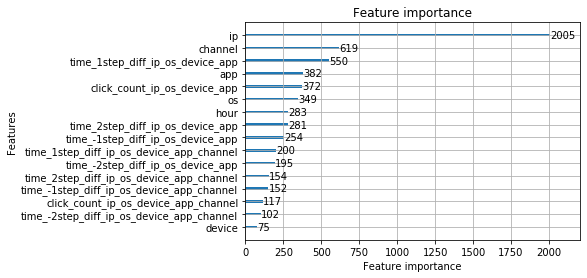

In [47]:
lgb.plot_importance(bst)

It looks like the model learns the IPs which might be ok if the IPs remain consistent in the data on which we use the model to make predictions.

For a robust model that does not overfit on IP, a new model can be trained with the IP predictor removed.

## Validation

Make predictions on the test set and check them online on Kaggle.

In [21]:
%%time
preds = np.array([])
for i, chunk in enumerate(np.array_split(test_df, 40)):
    print(i)
    preds = np.append(preds, bst.predict(chunk[predictors], num_iteration=bst.best_iteration))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Wall time: 6min 38s


In [31]:
# check same size
preds.size, test_df.shape[0]

(18790469, 18790469)

In [32]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
sub['is_attributed'] = preds

sub.to_csv('submission.csv',     # filename
           index=False,          # don't write row names
           float_format='%.9f')  # format floats as strings

The predictions received an area under the ROC curve score of: 0.97578.